In [1]:
import math
import numpy as np
import scipy as sp
import imageio as imio
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from mpl_toolkits.mplot3d import Axes3D #3d plotting functions
from matplotlib import pyplot
from PIL import Image

from copy import deepcopy  #deepcopy ensures that a copy of all the object data is performed (not just the pointers)

import os


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler



/home/alessandro/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alessandro/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
imPath  = "images"
imFiles = [os.path.join(imPath,f) for f in os.listdir(imPath) if os.path.isfile(os.path.join(imPath, f))]

images = []

for file in imFiles:
    images.append(Image.open(file))

In [3]:
im = images[0]

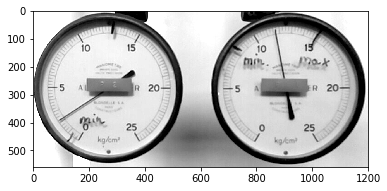

In [4]:
plt.imshow(im)

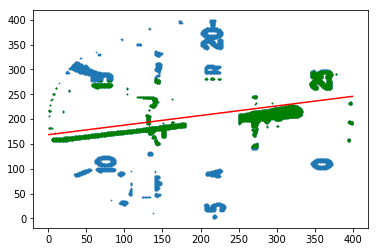

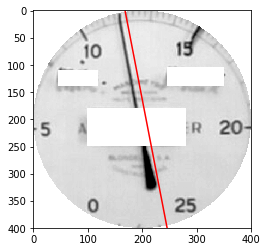

angle= 100.95393627176087


In [7]:
def crop_circle_jpg(m, cx, cy, r):
    m_crop = np.ones((2*r,2*r,m.shape[2]), dtype=np.int32)*255
    for i in range(2*r):
        for j in range(2*r):
            ii=cx-r+i
            jj=cy-r+j
            if np.sqrt(np.square(ii-cx)+np.square(jj-cy))<r:
                m_crop[i,j]=m[ii,jj]
    return m_crop



def read_left(image, plot=False):
    #crop circle image
    im_left  = crop_circle_jpg(np.asarray(image), 270,270,150)
    #remove blocks(min and central square)
    im_left[120:200,70:240]=[255,255,255]
    im_left[250:,:]=[255,255,255]
    
    #set "white" threshold
    trsh = 180
    im_left_coords = np.where(np.mean(im_left,axis=2)<trsh)
    im_left_coords =np.array(im_left_coords)
        
    #first fit
    reg = np.polyfit(im_left_coords[0], im_left_coords[1], deg=1, full=True)
    fit =reg[0]
    res=reg[1][0]
    
    # Make predictions
    y_pred = im_left_coords[0]*fit[0]+fit[1]
    
    #l1 error for rejection
    l1_err = np.mean(np.abs(im_left_coords[1]-y_pred))
    #l1 1-sigma rejection
    im_left_rej = im_left_coords[:,np.abs(im_left_coords[1]-y_pred)<l1_err]
    #second fit
    reg = np.polyfit(im_left_rej[0], im_left_rej[1], deg=1, full=True)
    fit =reg[0]
    res=reg[1][0]
    y_pred = im_left_rej[0]*fit[0]+fit[1]
    #angle estimation 90+ since jpg system is rotated respect to pixel notation
    theta =90+np.arctan(fit[0])*180/np.pi
    if plot:
        plt.scatter(im_left_coords[0],im_left_coords[1], s=0.5)
        plt.scatter(im_left_rej[0],im_left_rej[1], s=0.5, c='green')
        plt.plot(im_left_rej[0], y_pred, c='red')
        plt.show()
        
        plt.imshow(im_left)
        plt.plot(y_pred,im_left_rej[0],  c='red')
        plt.show()
    return theta



def read_right(image, plot=False):
    #crop circle image
    im_rigth = crop_circle_jpg(np.asarray(image), 260,910,200)
    #remove blocks(min and central square)
    im_rigth[180:250,100:280]=[255,255,255]
    im_rigth[110:140,45:120]=[255,255,255]
    im_rigth[105:140,245:350]=[255,255,255]
    
    #set "white" threshold
    trsh = 180
    im_right_coords = np.where(np.mean(im_rigth,axis=2)<trsh)
    im_right_coords =np.array(im_right_coords)
        
    #first fit
    reg = np.polyfit(im_right_coords[0], im_right_coords[1], deg=1, full=True)
    fit =reg[0]
    res=reg[1][0]
    
    # Make predictions
    y_pred = im_right_coords[0]*fit[0]+fit[1]
    
    #l1 error for rejection
    l1_err = np.mean(np.abs(im_right_coords[1]-y_pred))
    #l1 1-sigma rejection
    im_right_rej = im_right_coords[:,np.abs(im_right_coords[1]-y_pred)<l1_err]
    #second fit
    reg = np.polyfit(im_right_rej[0], im_right_rej[1], deg=1, full=True)
    fit =reg[0]
    res=reg[1][0]
    y_pred = im_right_rej[0]*fit[0]+fit[1]
    #angle estimation 90+ since jpg system is rotated respect to pixel notation
    theta =90+np.arctan(fit[0])*180/np.pi
    if plot:
        plt.scatter(im_right_coords[0],im_right_coords[1], s=0.5)
        plt.scatter(im_right_rej[0],im_right_rej[1], s=0.5, c='green')
        plt.plot(im_right_rej[0], y_pred, c='red')
        plt.show()
        
        plt.imshow(im_rigth)
        plt.plot(y_pred,im_right_rej[0],  c='red')
        plt.show()
    return theta

th =  read_right(im, plot=True)
print("angle=", th)

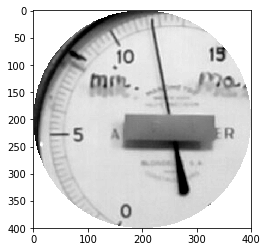

In [5]:
def crop_circle_jpg(m, cx, cy, r):
    m_crop = np.ones((2*r,2*r,m.shape[2]), dtype=np.int32)*255
    for i in range(2*r):
        for j in range(2*r):
            ii=cx-r+i
            jj=cy-r+j
            if np.sqrt(np.square(ii-cx)+np.square(jj-cy))<r:
                m_crop[i,j]=m[ii,jj]
    return m_crop



im_mat=np.asarray(im)


im_crop = crop_circle_jpg(im_mat, 250, 850, 200)



plt.imshow(im_crop)

In [49]:
im_left  = crop_circle_jpg(im_mat, 270,270,150)
im_rigth = crop_circle_jpg(im_mat, 250,900,200)

im_left[120:200,70:240]=[255,255,255]
im_left[250:,:]=[255,255,255]

trsh = 180
im_left_coords = np.where(np.mean(im_left,axis=2)<trsh)
im_left_coords =np.array(im_left_coords)

#regr = linear_model.LinearRegression()
#regr.fit(im_left_coords[0].reshape(1,-1), im_left_coords[1].reshape(1,-1))

reg = np.polyfit(im_left_coords[0], im_left_coords[1], deg=1, full=True)
fit =reg[0]
res=reg[1][0]

# Make predictions using the testing set
y_pred = im_left_coords[0]*fit[0]+fit[1]


l1_err = np.mean(np.abs(im_left_coords[1]-y_pred))

im_left_rej = im_left_coords[:,np.abs(im_left_coords[1]-y_pred)<l1_err]

reg = np.polyfit(im_left_rej[0], im_left_rej[1], deg=1, full=True)
fit =reg[0]
res=reg[1][0]
y_pred = im_left_rej[0]*fit[0]+fit[1]


34.308923810533095


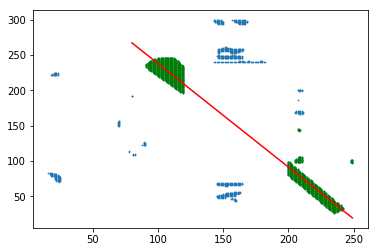

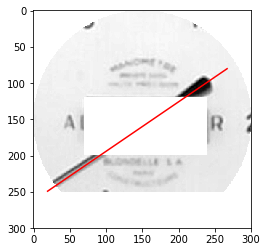

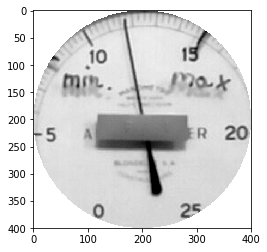

In [58]:
print(90+np.arctan(fit[0])*180/np.pi)

plt.scatter(im_left_coords[0],im_left_coords[1], s=0.5)
plt.scatter(im_left_rej[0],im_left_rej[1], s=0.5, c='green')
plt.plot(im_left_rej[0], y_pred, c='red')
plt.show()

plt.imshow(im_left)
plt.plot(y_pred,im_left_rej[0],  c='red')
plt.show()
plt.imshow(im_rigth)

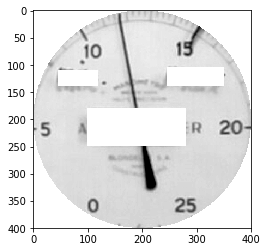

In [85]:
im_rigth = crop_circle_jpg(im_mat, 260,910,200)
im_rigth[180:250,100:280]=[255,255,255]
im_rigth[110:140,45:120]=[255,255,255]
im_rigth[105:140,245:350]=[255,255,255]
plt.imshow(im_rigth)

In [ ]:
#convert to RGB matrix

#png
#datat = im.reshape(im.shape[0]*image1.shape[1], image1.shape[2])/255

#jpg
im_mat=np.asarray(im)
datat=im_mat.reshape(im_mat.shape[0]*im_mat.shape[1], im_mat.shape[2])/255

data = datat[:,0:3] #this is for rgb
print(datat.shape)
print(data.shape)


In [ ]:
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
r, g, b = list(data[:,0]), list(data[:,1]), list(data[:,2])

axis.scatter(r, g, b, c=data, s=5, marker="o")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
pyplot.show()

In [7]:
#clustering

kmeans = KMeans(4, n_init=20, max_iter=50)
kmeans.fit(data)

spclusters=np.hstack((data, kmeans.labels_.reshape(len(kmeans.labels_),1)))
spcenters=kmeans.cluster_centers_

In [8]:
sp_image=np.zeros(data.shape)
l=data.shape[0]

for i in range(l):
    if spclusters[i,3]==0 :
        sp_image[i]=[0,0,0]
    if spclusters[i,3]==1 :
        sp_image[i]=[0,255,0]
    if spclusters[i,3]==2 :
        sp_image[i]=[255,0,0]
    if spclusters[i,3]==2 :
        sp_image[i]=[0,0,255]

im_arr = np.array(sp_image)
sp_image=sp_image.reshape((400, 400, 3))
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(sp_image)
plt.show()

ValueError: cannot reshape array of size 2012400 into shape (400,400,3)

In [ ]:
plt.imshow(im)

In [ ]:
im_bw= im.convert('1')
plt.imshow(im_bw)

In [ ]:
im_mat=np.asarray(im_bw)
im_mat.shape

In [ ]:
points = np.where(im_mat==False)
coords = np.array([[x,y] for x,y in zip(points[0],points[1])])

plt.scatter(coords[:,0], coords[:,1], s=0.5)

In [ ]:
X = StandardScaler().fit_transform(coords)
db = DBSCAN(eps=1, min_samples=5).fit(X)
labels = db.labels_

unique_labels = set(labels)
colors = ['red', 'green', 'blue']

col = [colors[l] for l in labels]

plt.scatter(coords[:,0], coords[:,1], color=col, s=0.5)

In [67]:
colors[0][2]

0.25882352941176473